# Diving into Diamond Data: Analysis of the Diamond Market

## Imports

In [18]:
#import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [3]:
#load the file into a dataframe
data = pd.read_csv('DiamondData.csv')
print('Original Data Shape: ', data.shape)
#data.head

Original Data Shape:  (50000, 10)


## Cleaning the data

In [4]:
#remove all leading and trailing spaces in the data
data.columns = data.columns.str.strip()

In [5]:
#check if there are duplicates, if so remove them
dups = data.duplicated()

if dups.sum() == 0:
    print('There are no duplicates')
    
else:
    print('The number of duplicate rows: ', dups.sum())
    data = data.drop_duplicates()
    print('The duplicates have been dropped \n')
    print('New Data Shape: ', data.shape)

The number of duplicate rows:  115
The duplicates have been dropped 

New Data Shape:  (49885, 10)


In [6]:
#Print the number of missing values
print('Number of Instances = %d\nNumber of Attributes = %d' % (data.shape[0], data.shape[1]))
print('------------------------------')
print('Number of Missing Values ')
data.isnull().sum()

Number of Instances = 49885
Number of Attributes = 10
------------------------------
Number of Missing Values 


carat        0
cut          0
color        0
clarity      0
depth      471
table      390
price      253
x          221
y          333
z          428
dtype: int64

#### Since there is a small number of rows with missing values, we will drop any rows with a null value. There will still be a large data set to run analysis.

In [7]:
#We will drop any rows that have a null value
data = data.dropna(axis = 'rows', subset = ['price', 'depth', 'table', 'x', 'y', 'z'])
print('New Data Shape: ', data.shape)
data.isnull().sum()

New Data Shape:  (47825, 10)


carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

In [8]:
#impute missing values with median
#data = data.fillna(data.median())
#data.isnull().sum()

#### Find the typos and categories of the non-integer groups

In [9]:
#Find typos and categories of the non-integer groups
print('Breakdown of the Non-Integer 4 Cs')
print('\n', data.groupby('color').size())
print('\n', data.groupby('cut').size())
print('\n', data.groupby('clarity').size())

Breakdown of the Non-Integer 4 Cs

 color
D     5975
E     8700
F     8438
G    10035
H     7361
I     4830
J     2486
dtype: int64

 cut
Fair          1408
Good          4351
Ideal        19091
Premium      12242
Very Geod     2153
Very Good     8580
dtype: int64

 clarity
I1        654
IF       1590
SI1     11583
SI2      8105
VS1      7230
VS2     10932
VVS1     3243
VVS2     4488
dtype: int64


In [10]:
#Replace typo values with real values
data = data.replace('Very Geod', 'Very Good')
data.groupby('cut').size()

cut
Fair          1408
Good          4351
Ideal        19091
Premium      12242
Very Good    10733
dtype: int64

#### Since cut, color, and clarity are ordinal, we can numerically place each value on a scale

In [11]:
#Since cut, color, and clarity are ordinal, we can numerically place each value on a scale
#We will use a scale of: 
#0 - 6 for color (0 = J and 6 = D)
#0 - 4 for cut (0 = fair and 4 = Ideal)
#0 - 7 for clarity (0 = I1 and 7 = IF)

#color
data = data.replace('D', '6')
data = data.replace('E', '5')
data = data.replace('F', '4')
data = data.replace('G', '3')
data = data.replace('H', '2')
data = data.replace('I', '1')
data = data.replace('J', '0')

#cut
data = data.replace('Ideal', '4')
data = data.replace('Premium', '3')
data = data.replace('Very Good', '2')
data = data.replace('Good', '1')
data = data.replace('Fair', '0')

#clarity
data = data.replace('IF', '7')
data = data.replace('VVS1', '6')
data = data.replace('VVS2', '5')
data = data.replace('VS1', '4')
data = data.replace('VS2', '3')
data = data.replace('SI1', '2')
data = data.replace('SI2', '1')
data = data.replace('I1', '0')

### Discover outliers and eliminate them

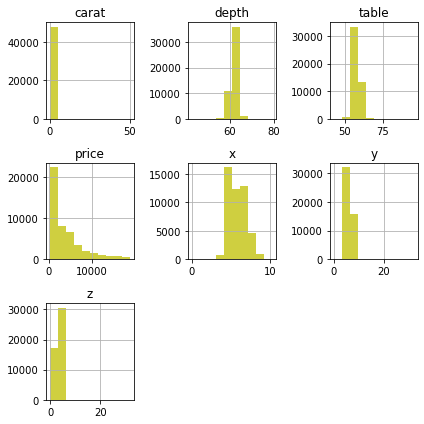

In [12]:
#Histogram of numerical values
data[['carat', 'depth', 'table', 'price', 'x', 'y','z']].hist(figsize=(6, 6), bins=10, alpha = 0.75, color = 'y')
plt.tight_layout()
plt.show()

<AxesSubplot:>

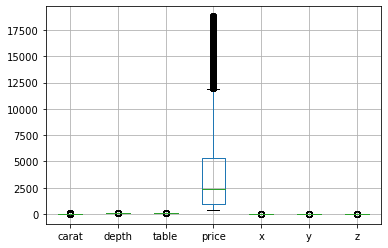

In [13]:
data.boxplot()

<AxesSubplot:>

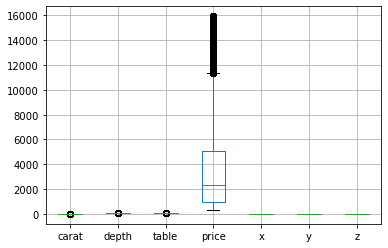

In [14]:
#Eliminate Outliers using a Standard Deviation model
for colName in data.columns:
    if data[colName].dtype == 'float64':
        mean = np.mean(data[colName])
        stdev = np.std(data[colName])
        cutoff = 3*stdev #using 3 standard deviations for outliers
        lower_range = mean - cutoff
        upper_range = mean + cutoff
        data = data[(data[colName] < upper_range) & (data[colName] > lower_range)]
        

#Graph a boxplot to visualize outliers 
data.boxplot()

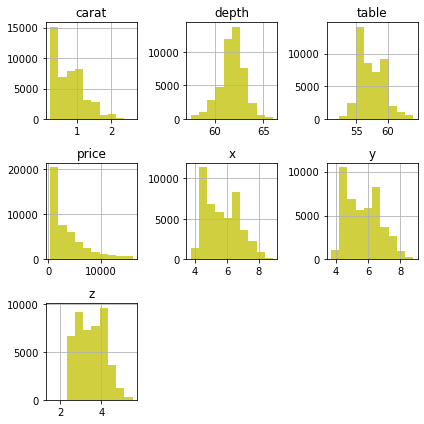

In [15]:
#Histogram of numerical values
data[['carat', 'depth', 'table', 'price', 'x', 'y','z']].hist(figsize=(6, 6), bins=10, alpha = 0.75, color = 'y')
plt.tight_layout()
plt.show()

In [16]:
#Determine the correlations of each numerical feature
corr = data.corr()
corr

,carat,depth,table,price,x,y,z
carat,1.000000,0.025485,0.186475,0.923786,0.981210,0.980271,0.980259
depth,0.025485,1.000000,-0.281479,-0.002219,-0.024285,-0.026758,0.088109
table,0.186475,-0.281479,1.000000,0.132844,0.194348,0.189311,0.160309
price,0.923786,-0.002219,0.132844,1.000000,0.892452,0.893656,0.889490
x,0.981210,-0.024285,0.194348,0.892452,1.000000,0.998651,0.992710
y,0.980271,-0.026758,0.189311,0.893656,0.998651,1.000000,0.992349
z,0.980259,0.088109,0.160309,0.889490,0.992710,0.992349,1.000000


Price has the strongest correlation with carat and the x, y, and z dimensions. Carat also has a strong positive correlation with the x, y, and z dimnesions, likely because, as the weight of the diamond increases, so does the general size. Overall, the depth and table have very weak correlation with any of the other features except for each other; which is a weak negative correlation.

In [17]:
data.describe()

,carat,depth,table,price,x,y,z
count,45767.000000,45767.000000,45767.000000,45767.000000,45767.000000,45767.000000,45767.000000
mean,0.765479,61.750888,57.378900,3628.557563,5.668323,5.671590,3.500911
std,0.433613,1.270457,2.105371,3492.347699,1.068175,1.060989,0.659537
min,0.200000,57.500000,51.000000,326.000000,3.730000,3.680000,1.530000
25%,0.390000,61.100000,56.000000,928.000000,4.690000,4.700000,2.890000
50%,0.700000,61.800000,57.000000,2317.000000,5.660000,5.670000,3.500000
75%,1.020000,62.500000,59.000000,5098.000000,6.490000,6.490000,4.020000
max,2.630000,66.000000,64.000000,15937.000000,8.880000,8.810000,5.510000


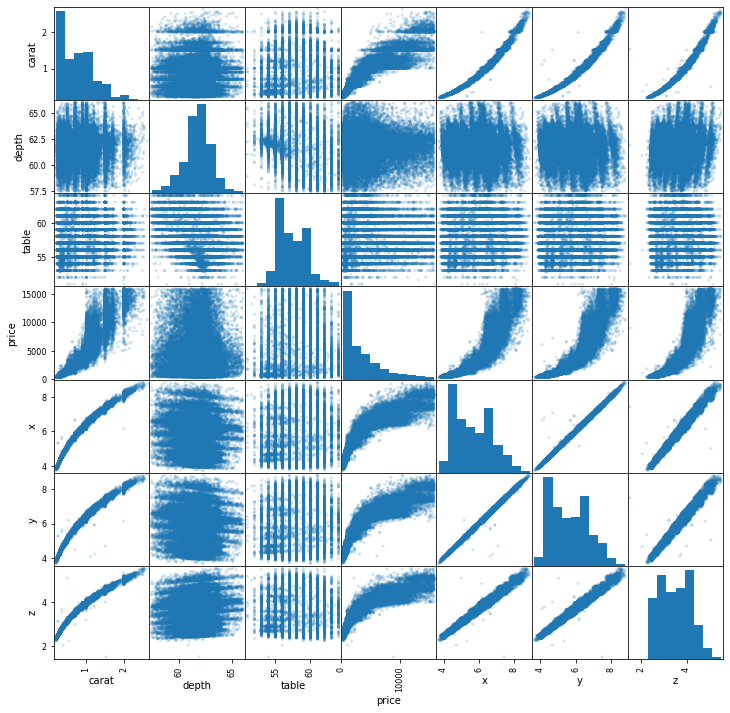

In [19]:
# Draw a scatter matrix for the data
axes = scatter_matrix(data, alpha=0.2, figsize = (12, 12))

In [25]:
data.head(5)

,carat,cut,color,clarity,depth,table,price,x,y,z
0,1.50,0,3,2,64.5,57.0,10352.0,7.15,7.09,4.59
1,0.70,4,5,3,61.4,57.0,2274.0,5.72,5.78,3.53
2,1.22,3,3,4,61.3,58.0,8779.0,6.91,6.89,4.23
3,0.51,3,5,3,62.5,60.0,1590.0,5.08,5.10,3.18
4,2.02,2,0,1,59.2,60.0,11757.0,8.27,8.39,4.91


## Visualize the Data

#### Plot the Price by Carat, Cut, Clarity, and Color

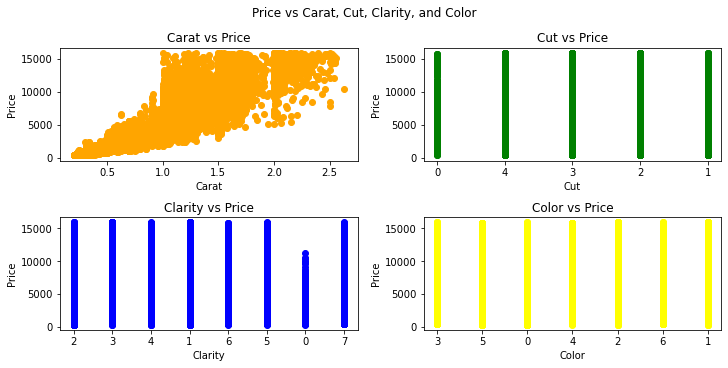

In [28]:
fig, ([plt1, plt2], [plt3, plt4]) = plt.subplots(2, 2, figsize = (10,5), constrained_layout = True)
fig.suptitle('Price vs Carat, Cut, Clarity, and Color')

# Carat vs Price
plt1.scatter(data.carat, data.price, c = 'orange')
plt1.set_xlabel('Carat', fontsize = 10)
plt1.set_ylabel('Price', fontsize = 10)
plt1.title.set_text('Carat vs Price')

# Cut vs Price
plt2.scatter(data.cut, data.price, c = 'green')
plt2.set_xlabel('Cut', fontsize = 10)
plt2.set_ylabel('Price', fontsize = 10)
plt2.title.set_text('Cut vs Price')

# Clarity vs Price
plt3.scatter(data.clarity, data.price, c = 'blue')
plt3.set_xlabel('Clarity', fontsize = 10)
plt3.set_ylabel('Price', fontsize = 10)
plt3.title.set_text('Clarity vs Price')

# Color vs Price
plt4.scatter(data.color, data.price, c = 'yellow')
plt4.set_xlabel('Color', fontsize = 10)
plt4.set_ylabel('Price', fontsize = 10)
plt4.title.set_text('Color vs Price')

plt.show()

#### From the scatter plots of price vs carat, cut, clarity, and color

## Multiple Regression Analysis 

In [219]:
X = data[['carat','cut','clarity','color','depth','table','x','y','z']]
y = np.array(data['price'])

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

In [220]:
model = LinearRegression()
clf = model.fit(X,y)
print('Coefficient: ', clf.coef_)

Coefficient:  [10787.01461097    90.09990056   460.8471623    299.13652369
   -35.64996544   -26.22729893  -728.16719977    18.76472428
  -438.41278547]


In [221]:
predictions = model.predict(X)
rmse = mean_squared_error(y, predictions, squared = False)
print('RMSE: ', rmse)

RMSE:  1023.5415598557569


The RMSE is lower than the price standard deviation, which means the model between carat and price is predicting some of the variability in price. 

ValueError: x and y must be the same size

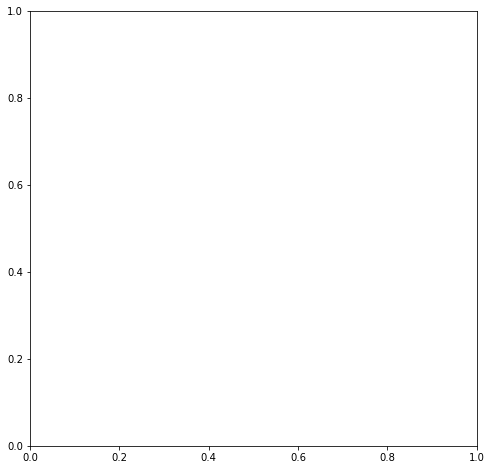

In [209]:
plt.scatter(x,y)
plt.plot(x, predictions)

In [223]:
plt.scatter(data['carat'])

TypeError: scatter() missing 1 required positional argument: 'y'